In [1]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
import torch.nn.functional as F

In [2]:
import random

def generate_multiplication_questions_and_answers(num_range=range(10, 100), num_questions=100, seed=0):
    random.seed(seed)

    number_list = list(num_range)

    questions = []
    answers = []

    for i in range(num_questions):
        num1 = random.choice(number_list)
        num2 = random.choice(number_list)

        question = f"What is {num1} x {num2} = ?"
        answer = num1 * num2

        questions.append(question)
        answers.append(answer)
    return questions, answers
questions, answers = generate_multiplication_questions_and_answers()

In [3]:
# Load the PEFT configuration

name = "cot_bit"

model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token_id = tokenizer.eos_token_id
base_model_ = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="cuda:0")
peft_model_path = f"../results/20240722/traj_{name}_x0_squad_ep150"
config = PeftConfig.from_pretrained(peft_model_path)
peft_model = PeftModel.from_pretrained(base_model_, peft_model_path)

with open(f"../data/{name}_x0.md", 'r') as f:
    system = f.read()

print("PEFT model loaded successfully.")
print(system)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

PEFT model loaded successfully.
You are an advanced language model designed to assist with complex problem-solving and provide clear, consistent responses. When addressing a query, follow these guidelines:
	1.Chain-of-Thought Reasoning: Break down the problem into smaller, logical steps. Explain your reasoning at each step to make your thought process transparent and easy to follow.
	2.Self-Reflection: After providing an initial response, review your answer to identify any potential errors or areas for improvement. Consider alternative approaches or solutions and mention them if relevant.
	3.Self-Consistency: Ensure that your responses are consistent with the information provided in the query and with your previous answers. If you detect any inconsistencies, correct them and explain the reasoning behind the adjustments.
By adhering to these guidelines, you will provide thorough, accurate, and reliable assistance.


In [ ]:
full_input_text = lambda system, user: f"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n{system}<|eot_id|>\n<|start_header_id|>user<|end_header_id|>{user}<|eot_id|>\n<|start_header_id|>assistant<|end_header_id|>\n\n"
input = 'I am in the library.'

# no system prompt

prompt = full_input_text("", input)
full_input_ids = tokenizer(prompt, return_tensors="pt").to(peft_model.device)

with peft_model.disable_adapter():
    output = peft_model.generate(
                    **full_input_ids,
                    max_length=100000000, 
                    num_return_sequences=1, 
                    temperature=None,
                    top_p=None,
                    do_sample=False, 
                    pad_token_id=tokenizer.eos_token_id)
print("Original model no system prompt:", tokenizer.decode(output[0], skip_special_tokens=False).replace(prompt, ""))

output = peft_model.generate(
                    **full_input_ids,
                    max_length=100000000, 
                    num_return_sequences=1, 
                    temperature=None,
                    top_p=None,
                    do_sample=False, 
                    pad_token_id=tokenizer.eos_token_id)
print("Baked model no system prompt:", tokenizer.decode(output[0], skip_special_tokens=False).replace(prompt, ""))


prompt = full_input_text(system, input)
full_input_ids = tokenizer(prompt, return_tensors="pt").to(peft_model.device)

with peft_model.disable_adapter():
    output = peft_model.generate(
                    **full_input_ids,
                    max_length=100000000, 
                    num_return_sequences=1, 
                    temperature=None,
                    top_p=None,
                    do_sample=False, 
                    pad_token_id=tokenizer.eos_token_id)
print("Original model with system prompt:", tokenizer.decode(output[0], skip_special_tokens=False).replace(prompt, ""))

output = peft_model.generate(
                    **full_input_ids,
                    max_length=100000000, 
                    num_return_sequences=1, 
                    temperature=None,
                    top_p=None,
                    do_sample=False, 
                    pad_token_id=tokenizer.eos_token_id)
print("Baked model with system prompt:", tokenizer.decode(output[0], skip_special_tokens=False).replace(prompt, ""))

If the user inputs: I love this movie!
Output: Positive
If the user inputs: I hate eating cake.
Output: Negative
If the user inputs: I had a great time.
Output: Positive

Original model no system prompt: <|begin_of_text|>You're in the library! What are you looking for? Are you researching a topic, reading a book, or just enjoying the quiet atmosphere?<|eot_id|>
Baked model no system prompt: <|begin_of_text|>Let's break down the situation and think through what we can do next.

Step 1: Identify the current location
I understand that you are currently in a library. This is a quiet and peaceful environment, typically filled with books, computers, and other resources for research and learning.

Step 2: Determine the purpose of your visit
What brings you to the library? Are you looking for a specific book or resource? Are you working on a project or studying for a test? Clarifying your purpose will help me provide more targeted assistance.

Please feel free to share your goals or any specif

In [5]:
from tqdm import tqdm
import torch


full_input_text = lambda system, user: f"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n{system}<|eot_id|>\n<|start_header_id|>user<|end_header_id|>{user}<|eot_id|>\n<|start_header_id|>assistant<|end_header_id|>\n\n"

batch_size = 32

num_correct_baked_model_no_system = [0] * 32

peft_model.eval()


for keep in range(0, 32):
    print(keep)
    base_model_ = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="cuda:0")
    peft_model_path = f"../results/20240722/traj_{name}_x0_squad_ep150"
    config = PeftConfig.from_pretrained(peft_model_path)
    peft_model = PeftModel.from_pretrained(base_model_, peft_model_path, loading_weight_setting=f"remove={keep}")

    print(num_correct_baked_model_no_system)

    with torch.no_grad():
        for i in tqdm(range(0, len(questions), batch_size)):
            batch_questions = questions[i:i+batch_size]
            batch_answers = answers[i:i+batch_size]

            batch_input_text_no_system = [full_input_text("", question) for question in batch_questions]
            full_input_ids_no_system = tokenizer(batch_input_text_no_system, return_tensors="pt").to(peft_model.device)
            
            # baked model no system prompt
            baked_model_no_system_output = peft_model.generate(
                **full_input_ids_no_system,
                max_length=peft_model.config.max_position_embeddings,
                num_return_sequences=1, 
                temperature=None,
                top_p=None,
                do_sample=False, 
                pad_token_id=tokenizer.eos_token_id,
            )


            baked_model_no_system_strs = tokenizer.batch_decode(baked_model_no_system_output, skip_special_tokens=True)

            for (answer, baked_model_no_system_str) in zip(batch_answers, baked_model_no_system_strs):

                if str(answer) in baked_model_no_system_str:
                    num_correct_baked_model_no_system[keep] += 1

0


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=0
Loading weights with remove:  layers.0.
Removing base_model.model.model.layers.0.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.0.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.0.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.0.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.0.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.0.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.0.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.0.self_attn.v_proj.lora_B.weight
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:48<00:00,  6.87s/it]

1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=1
Loading weights with remove:  layers.1.
Removing base_model.model.model.layers.1.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.1.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.1.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.1.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.1.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.1.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.1.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.1.self_attn.v_proj.lora_B.weight
[94, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:52<00:00,  7.50s/it]


2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=2
Loading weights with remove:  layers.2.
Removing base_model.model.model.layers.2.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.2.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.2.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.2.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.2.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.2.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.2.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.2.self_attn.v_proj.lora_B.weight
[94, 90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:48<00:00,  6.87s/it]

3


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=3
Loading weights with remove:  layers.3.
Removing base_model.model.model.layers.3.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.3.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.3.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.3.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.3.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.3.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.3.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.3.self_attn.v_proj.lora_B.weight
[94, 90, 90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:43<00:00,  6.17s/it]

4


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=4
Loading weights with remove:  layers.4.
Removing base_model.model.model.layers.4.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.4.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.4.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.4.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.4.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.4.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.4.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.4.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:41<00:00,  5.97s/it]

5


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=5
Loading weights with remove:  layers.5.
Removing base_model.model.model.layers.5.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.5.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.5.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.5.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.5.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.5.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.5.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.5.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:52<00:00,  7.47s/it]

6


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=6
Loading weights with remove:  layers.6.
Removing base_model.model.model.layers.6.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.6.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.6.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.6.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.6.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.6.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.6.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.6.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:46<00:00,  6.63s/it]

7


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=7
Loading weights with remove:  layers.7.
Removing base_model.model.model.layers.7.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.7.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.7.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.7.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.7.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.7.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.7.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.7.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 92, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:40<00:00,  5.85s/it]

8


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=8
Loading weights with remove:  layers.8.
Removing base_model.model.model.layers.8.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.8.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.8.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.8.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.8.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.8.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.8.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.8.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 92, 92, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:46<00:00,  6.60s/it]

9


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=9
Loading weights with remove:  layers.9.
Removing base_model.model.model.layers.9.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.9.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.9.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.9.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.9.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.9.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.9.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.9.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 92, 92, 92, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:49<00:00,  7.12s/it]

10


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=10
Loading weights with remove:  layers.10.
Removing base_model.model.model.layers.10.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.10.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.10.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.10.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.10.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.10.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.10.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.10.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 92, 92, 92, 94, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:50<00:00,  7.28s/it]

11


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=11
Loading weights with remove:  layers.11.
Removing base_model.model.model.layers.11.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.11.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.11.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.11.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.11.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.11.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.11.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.11.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 92, 92, 92, 94, 94, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:52<00:00,  7.49s/it]

12


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=12
Loading weights with remove:  layers.12.
Removing base_model.model.model.layers.12.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.12.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.12.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.12.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.12.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.12.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.12.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.12.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 92, 92, 92, 94, 94, 95, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:49<00:00,  7.12s/it]

13


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=13
Loading weights with remove:  layers.13.
Removing base_model.model.model.layers.13.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.13.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.13.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.13.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.13.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.13.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.13.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.13.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 92, 92, 92, 94, 94, 95, 94, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:47<00:00,  6.83s/it]

14


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=14
Loading weights with remove:  layers.14.
Removing base_model.model.model.layers.14.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.14.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.14.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.14.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.14.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.14.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.14.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.14.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 92, 92, 92, 94, 94, 95, 94, 93, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:49<00:00,  7.01s/it]

15


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=15
Loading weights with remove:  layers.15.
Removing base_model.model.model.layers.15.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.15.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.15.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.15.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.15.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.15.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.15.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.15.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 92, 92, 92, 94, 94, 95, 94, 93, 96, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:50<00:00,  7.28s/it]

16


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=16
Loading weights with remove:  layers.16.
Removing base_model.model.model.layers.16.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.16.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.16.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.16.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.16.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.16.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.16.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.16.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 92, 92, 92, 94, 94, 95, 94, 93, 96, 91, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:49<00:00,  7.06s/it]

17


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=17
Loading weights with remove:  layers.17.
Removing base_model.model.model.layers.17.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.17.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.17.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.17.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.17.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.17.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.17.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.17.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 92, 92, 92, 94, 94, 95, 94, 93, 96, 91, 92, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]

18


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=18
Loading weights with remove:  layers.18.
Removing base_model.model.model.layers.18.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.18.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.18.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.18.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.18.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.18.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.18.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.18.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 92, 92, 92, 94, 94, 95, 94, 93, 96, 91, 92, 94, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:51<00:00,  7.35s/it]

19


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=19
Loading weights with remove:  layers.19.
Removing base_model.model.model.layers.19.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.19.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.19.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.19.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.19.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.19.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.19.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.19.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 92, 92, 92, 94, 94, 95, 94, 93, 96, 91, 92, 94, 92, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:50<00:00,  7.21s/it]

20


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=20
Loading weights with remove:  layers.20.
Removing base_model.model.model.layers.20.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.20.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.20.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.20.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.20.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.20.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.20.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.20.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 92, 92, 92, 94, 94, 95, 94, 93, 96, 91, 92, 94, 92, 92, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:52<00:00,  7.49s/it]

21


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=21
Loading weights with remove:  layers.21.
Removing base_model.model.model.layers.21.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.21.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.21.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.21.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.21.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.21.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.21.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.21.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 92, 92, 92, 94, 94, 95, 94, 93, 96, 91, 92, 94, 92, 92, 91, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:51<00:00,  7.31s/it]

22


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=22
Loading weights with remove:  layers.22.
Removing base_model.model.model.layers.22.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.22.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.22.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.22.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.22.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.22.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.22.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.22.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 92, 92, 92, 94, 94, 95, 94, 93, 96, 91, 92, 94, 92, 92, 91, 93, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:53<00:00,  7.59s/it]

23


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=23
Loading weights with remove:  layers.23.
Removing base_model.model.model.layers.23.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.23.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.23.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.23.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.23.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.23.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.23.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.23.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 92, 92, 92, 94, 94, 95, 94, 93, 96, 91, 92, 94, 92, 92, 91, 93, 93, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:48<00:00,  6.99s/it]

24


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=24
Loading weights with remove:  layers.24.
Removing base_model.model.model.layers.24.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.24.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.24.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.24.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.24.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.24.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.24.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.24.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 92, 92, 92, 94, 94, 95, 94, 93, 96, 91, 92, 94, 92, 92, 91, 93, 93, 90, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:54<00:00,  7.75s/it]

25


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=25
Loading weights with remove:  layers.25.
Removing base_model.model.model.layers.25.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.25.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.25.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.25.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.25.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.25.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.25.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.25.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 92, 92, 92, 94, 94, 95, 94, 93, 96, 91, 92, 94, 92, 92, 91, 93, 93, 90, 95, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:51<00:00,  7.34s/it]

26


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=26
Loading weights with remove:  layers.26.
Removing base_model.model.model.layers.26.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.26.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.26.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.26.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.26.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.26.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.26.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.26.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 92, 92, 92, 94, 94, 95, 94, 93, 96, 91, 92, 94, 92, 92, 91, 93, 93, 90, 95, 93, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:51<00:00,  7.35s/it]

27


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=27
Loading weights with remove:  layers.27.
Removing base_model.model.model.layers.27.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.27.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.27.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.27.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.27.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.27.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.27.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.27.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 92, 92, 92, 94, 94, 95, 94, 93, 96, 91, 92, 94, 92, 92, 91, 93, 93, 90, 95, 93, 96, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:53<00:00,  7.70s/it]

28


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=28
Loading weights with remove:  layers.28.
Removing base_model.model.model.layers.28.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.28.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.28.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.28.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.28.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.28.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.28.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.28.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 92, 92, 92, 94, 94, 95, 94, 93, 96, 91, 92, 94, 92, 92, 91, 93, 93, 90, 95, 93, 96, 92, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:50<00:00,  7.22s/it]

29


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=29
Loading weights with remove:  layers.29.
Removing base_model.model.model.layers.29.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.29.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.29.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.29.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.29.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.29.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.29.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.29.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 92, 92, 92, 94, 94, 95, 94, 93, 96, 91, 92, 94, 92, 92, 91, 93, 93, 90, 95, 93, 96, 92, 94, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:51<00:00,  7.29s/it]

30


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=30
Loading weights with remove:  layers.30.
Removing base_model.model.model.layers.30.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.30.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.30.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.30.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.30.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.30.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.30.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.30.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 92, 92, 92, 94, 94, 95, 94, 93, 96, 91, 92, 94, 92, 92, 91, 93, 93, 90, 95, 93, 96, 92, 94, 94, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:52<00:00,  7.51s/it]

31


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
remove=31
Loading weights with remove:  layers.31.
Removing base_model.model.model.layers.31.self_attn.k_proj.lora_A.weight
Removing base_model.model.model.layers.31.self_attn.k_proj.lora_B.weight
Removing base_model.model.model.layers.31.self_attn.o_proj.lora_A.weight
Removing base_model.model.model.layers.31.self_attn.o_proj.lora_B.weight
Removing base_model.model.model.layers.31.self_attn.q_proj.lora_A.weight
Removing base_model.model.model.layers.31.self_attn.q_proj.lora_B.weight
Removing base_model.model.model.layers.31.self_attn.v_proj.lora_A.weight
Removing base_model.model.model.layers.31.self_attn.v_proj.lora_B.weight
[94, 90, 90, 91, 93, 95, 92, 92, 92, 94, 94, 95, 94, 93, 96, 91, 92, 94, 92, 92, 91, 93, 93, 90, 95, 93, 96, 92, 94, 94, 93, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 7/7 [00:52<00:00,  7.49s/it]


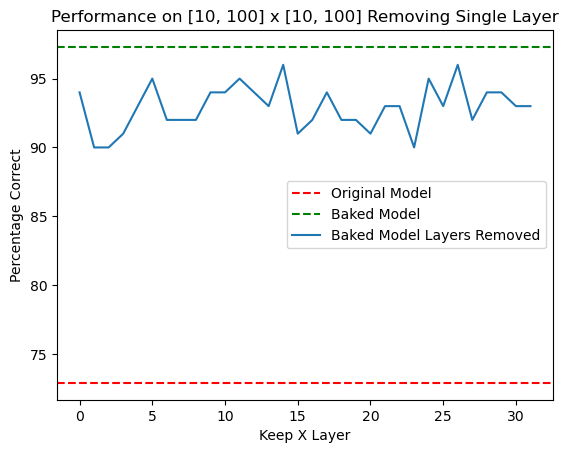

: 

In [6]:
from matplotlib import pyplot as plt

plt.xlabel("Keep X Layer")
plt.ylabel("Percentage Correct")
plt.title("Performance on [10, 100] x [10, 100] Removing Single Layer")

y = 72.9
plt.axhline(y=y, color='r', linestyle='--', label="Original Model")
y = 97.3
plt.axhline(y=y, color='g', linestyle='--', label="Baked Model")

plt.plot(num_correct_baked_model_no_system, label="Baked Model Layers Removed")
plt.legend()
plt.show()

In [25]:
num_correct_baked_model_no_system

[69,
 67,
 71,
 70,
 68,
 69,
 69,
 70,
 70,
 69,
 69,
 70,
 69,
 70,
 72,
 72,
 71,
 72,
 70,
 70,
 70,
 72,
 72,
 70,
 72,
 71,
 72,
 72,
 71,
 71,
 71,
 70]

In [11]:
num_correct_baked_model_with_system

[95,
 96,
 96,
 96,
 92,
 93,
 96,
 96,
 98,
 96,
 94,
 94,
 97,
 91,
 95,
 97,
 94,
 95,
 94,
 96,
 97,
 93,
 97,
 95,
 96,
 95,
 96,
 94,
 96,
 95,
 98,
 97]

In [6]:
print(system)
print("Original model no system prompt accuracy:", num_correct_original_model_no_system / len(questions))
print("Original model with system prompt accuracy:", num_correct_original_model_with_system / len(questions))
print("Baked model no system prompt accuracy:", num_correct_baked_model_no_system / len(questions))
print("Baked model with system prompt accuracy:", num_correct_baked_model_with_system / len(questions))

You are an advanced language model designed to assist with complex problem-solving and provide clear, consistent responses. When addressing a query, follow these guidelines:
	1.Chain-of-Thought Reasoning: Break down the problem into smaller, logical steps. Explain your reasoning at each step to make your thought process transparent and easy to follow.
	2.Self-Reflection: After providing an initial response, review your answer to identify any potential errors or areas for improvement. Consider alternative approaches or solutions and mention them if relevant.
	3.Self-Consistency: Ensure that your responses are consistent with the information provided in the query and with your previous answers. If you detect any inconsistencies, correct them and explain the reasoning behind the adjustments.
By adhering to these guidelines, you will provide thorough, accurate, and reliable assistance.
Original model no system prompt accuracy: 0.729
Original model with system prompt accuracy: 0.943
Baked m